In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import technical_analysis.backtest_kz as bt
from data_manipulation import DataManipulation
import warnings
warnings.simplefilter(action = 'ignore', category = pd.errors.PerformanceWarning)
%matplotlib inline

In [3]:
SYMBOL = 'SASA.IS'
scale = 1
range = [5, 10, 15, 20, 25, 30, 35, 40, 50, 99]
range = [i*scale for i in range]
period = '6mo'
interval = '1h'
start_date = ''
end_data = ''
source = 'yahoo'

In [4]:
data = DataManipulation(SYMBOL, source, range, period=period, interval=interval, scale=scale, prefix_path='..')

In [5]:
df = data.df
df.head()

,Open,High,Low,Close,Volume,sma_5,sma_10,sma_15,sma_20,sma_25,...,roc_25,roc_30,roc_35,roc_40,roc_50,roc_99,candlestick_pattern,candle_label,d_r,feature_label
Datetime,,,,,,,,,,,,,,,,,,,,,
2022-08-12 13:30:00+03:00,52.3500,52.5500,52.3000,52.4000,1440955,52.3600,52.7300,52.8733,52.3450,51.9860,...,3.8652,0.3831,2.0448,1.8465,4.5908,25.8405,CDLLONGLEGGEDDOJI_Bull,1.0000,0.0019,1.0000
2022-08-12 14:30:00+03:00,52.4500,53.5500,52.3500,53.2500,6429318,52.5200,52.7650,52.9167,52.4900,52.0880,...,5.0296,3.0978,3.8012,3.8012,7.2724,28.2514,NO_PATTERN,0.0000,0.0162,0.0000
2022-08-12 15:30:00+03:00,53.3000,53.4000,52.9000,53.0000,2755724,52.6400,52.7150,52.8500,52.6150,52.1960,...,5.3678,3.5156,2.1195,3.6168,7.0707,28.0193,CDLLONGLINE_Bear,-1.0000,-0.0047,0.0000
2022-08-12 16:30:00+03:00,52.8500,53.1000,52.1500,52.6000,4873756,52.7100,52.6300,52.8433,52.7200,52.2720,...,3.7475,2.8348,1.1538,3.0362,6.2197,25.7771,CDLHIKKAKE_Bull,1.0000,-0.0075,1.0000
2022-08-12 17:30:00+03:00,52.5500,52.8500,52.5000,52.6500,0,52.7800,52.6050,52.8067,52.7975,52.3540,...,4.0514,3.5398,0.6692,3.2353,6.2778,26.4409,NO_PATTERN,0.0000,0.0010,1.0000


In [6]:
bt_dict_result = bt.make_backtest(df, range)
bt_dict_result

no entry macd


[((1688.440743349636, 28), 'TRIMA_5_10'),
 ((1666.3863964006848, 10), 'tema_25_30'),
 ((1662.8938131607104, 4), 'kama_10_25'),
 ((1656.157711199597, 25), 'sma_5_10'),
 ((1609.8555564492578, 26), 'wma_5_10'),
 ((1529.0150476279193, 19), 't3_5_10'),
 ((1513.7953860941966, 3), 'dema_25_99'),
 ((1494.9032943923755, 33), 'cmo_10_35'),
 ((1494.4803636526376, 5), 'ema_10_50'),
 ((1384.3910169867358, 5), 'cci_30'),
 ((1287.6347279795464, 6), 'rsi_5'),
 ((1253.3186137042476, 6), 'band_50'),
 ((1224.846586992071, 8), 'wllr_20'),
 ((1146.5377516180104, 2), 'mfi_10'),
 ((1015.3461245023286, 1), 'band_5')]

In [7]:
bt.write_backtest_result(df, SYMBOL, period, interval, bt_dict_result)

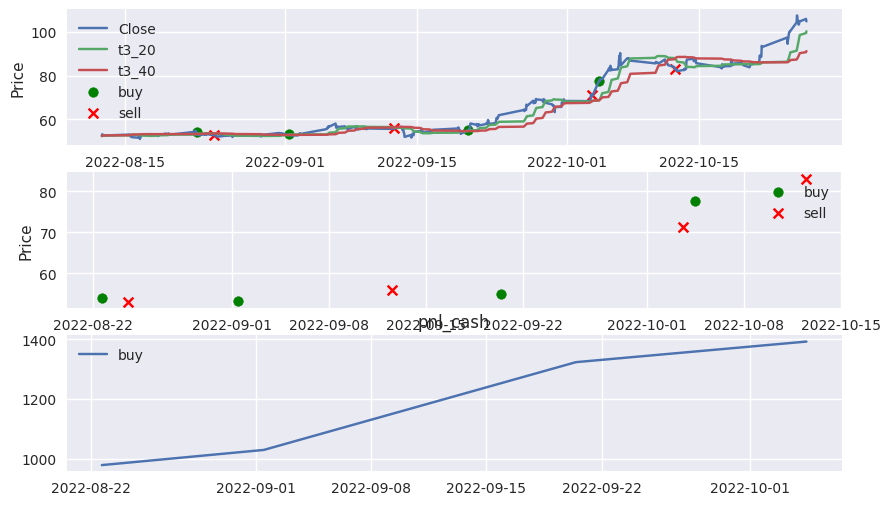

In [8]:
trade_sheet = bt.bt_crossover(df, 't3_20', 't3_40')
bt.bt_plot_crossover(df, trade_sheet, 't3_20', 't3_40')

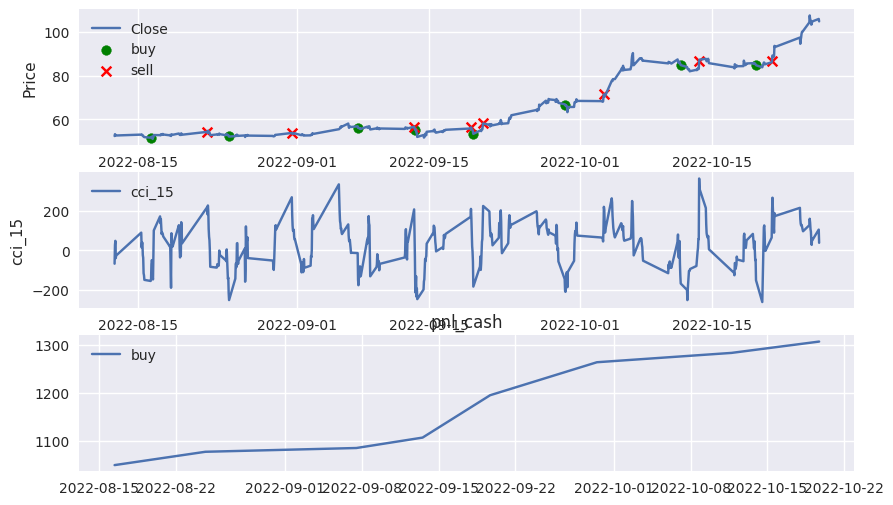

In [9]:
trade_sheet = bt.bt_threshold(df, 'cci_15', 200, -150)
bt.bt_plot_ind(df, trade_sheet, 'cci_15')

In [10]:
from twitter.twitter_collection import TwitterCollection
client = TwitterCollection()

Authentication Successfull


In [11]:
query_list = ['btc','eth','xrp','bnb', 'luna', 'matic', 'sol', 'ens', 'rune', 'dot']
query_list_bist = ['sumas', 'orma', 'xu100', 'bist', 'sasa']

In [12]:
query = 'sasa'
path_df = f'../data/tweets_data/{query}/'
file_df = f'{query}_tweets.csv'
df_tweet = client.get_tweets_df('sasa', path_df, file_df)
print(df_tweet.shape)
df_tweet.head()

(365098, 9)


,index_col,created_at,text,source,name,username,location,verified,description
0,0,2022-10-25 12:53:47+00:00,Mal kapma günü. Malını kaptıranlar üzülür #bis...,Twitter for iPhone,Yatırımcı Kedi,yatirimcikedi,NaN,False,NaN
1,1,2022-10-25 12:53:13+00:00,#sasa devletin hissesi olduğunu bu kadar belli...,Twitter for iPhone,Sarı,iamSari55,NaN,False,Kendine Yatırımcı ( tweetlerim kendime notları...
2,2,2022-10-25 12:52:50+00:00,+++ Sterlinin son aylarda kaybettiği değeri te...,Twitter Web App,M.Deniz Asoğlu,mdenizasoglu,Kadıköy/İstanbul,False,"Tesadüf,tedbil-i kıyafet gezen Tanrıdır….Çokça..."
3,3,2022-10-25 12:52:38+00:00,#Barbaros tavanladi saldı #bist100 saolsun #sa...,Twitter for Android,Mert SARIKAN,mert_sarikan,NaN,False,⚡Engineer | Designer | İnvestor\n\n#bist100 #x...
4,4,2022-10-25 12:50:11+00:00,#sasa düşmemeye yemin etmiş,Twitter for iPhone,Borsatrendiniz,borsatrendiniz,"İstanbul, Türkiye",False,Bu twitter hesabı dışında başka herhangi bir h...


In [16]:

query_list = ['btc','eth','xrp','bnb', 'luna', 'matic', 'sol', 'ens']
query_list_bist = ['sumas', 'orma', 'xu100', 'bist', 'sasa']
import datetime
from datetime import datetime as dt 
from datetime import timedelta as td

now = datetime.datetime.now(datetime.timezone.utc)

# finish_time = now - td(hours=24*6)
for i in query_list_bist:
    df_tweets = client.get_tweets_with_interval(i, 'tr', hour=24*1)
    print(f'shape of {i} tweets df: {df_tweets.shape}')
    path_df = f'../data/tweets_data/{i}/'
    file_df = f'{i}_tweets.csv'
    client.write_tweets_csv(df_tweets, path_df, file_df)

shape of sumas tweets df: (29, 8)
shape of orma tweets df: (61, 8)
shape of xu100 tweets df: (17544, 8)
shape of bist tweets df: (15827, 8)
shape of sasa tweets df: (68171, 8)


In [17]:
query = 'sasa'
path_df = f'../data/tweets_data/{query}/'
file_df = f'{query}_tweets.csv'
df_tweet = client.get_tweets_df('sasa', path_df, file_df)
print(df_tweet.shape)

(433269, 10)
